# **Production Engineering**

# *Nodal Analysis*

***

# 1. Python Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utilities import j, j_darcy, aof, Qb, qo_darcy, qo_vogel, qo_standing, qo_ipr_compuesto, IPR_Curve, IPR_curve_methods
import plotly.express as px

# 2. Important Functions for Nodal Analysis

In [3]:
def pwf_darcy(q_test, pwf_test, q, pr, pb):
    pwf = pr - (q / j(q_test, pwf_test, pr, pb))
    return pwf

In [4]:
# Pwf when Pr < Pb (Saturated reservoir)
def pwf_vogel(q_test, pwf_test, q, pr, pb):
    pwf = 0.125 * pr * (-1 + np.sqrt(81 - 80 * q / aof(q_test, pwf_test, pr, pb)))
    return pwf

In [6]:
# Friction factor (f) from Hanzel Williams equation
def f_hanzenW(Q, ID, C=120):
    f = (2.083 * (((100 * Q)/(34.3 * C))**1.85 * (1 / ID)**4.8655)) / 1000
    return f

In [7]:
# SGOil using API
def sg_oil(API):
    SG_oil = 141.5 / (131.5 + API)
    return SG_oil

In [8]:
# SG average of fluids
def sg_avg(API, wc, sg_h2o):
    sg_avg = wc * sg_h2o + (1-wc) * sg_oil(API)
    return sg_avg

In [9]:
# Average Gradient using fresh water gradient (0.433 psi/ft)
def gradient_avg(API, wc, sg_h2o):
    g_avg = sg_avg(API, wc, sg_h2o) * 0.433
    return g_avg

# 3. Monofasic Fluid Flow

# 3.1. Exercises

## *Ejercicio 1*

En base a la información de la tabla:

a) Calcule IP\
b) Calcule Qmax\
c) Calcule la gravedad específica promedio del fluido\
d) Calcule el gradiente promedio del fluido

In [52]:
# Data
Pr = 3000 #psia
Pb = 2300 # psia
Qt = 1500 #bpd
Pwft = 2400 #psia
THP = 360 #psia
wc = 0.9 
API = 20 
sg_h2o = 1.09
ID = 3.5 #in
tvd = 9000 #ft
md = 10500 #ft 
C = 120

## a) IP

In [53]:
IP = j(Qt, Pwft, Pr, Pb)
print(f"IP -> {IP} bpd/psia")

IP -> 2.5 bpd/psia


## b) Qmax

In [54]:
Qmax =  aof(Qt, Pwft, Pr, Pb)
print(f"Qmax -> {Qmax} bpd")

Qmax -> 7500.0 bpd


## c) SGavg

In [55]:
SGavg = sg_avg(API, wc, sg_h2o)
print(f"SGavg -> {SGavg:.2f}")

SGavg -> 1.07


## d) Gavg

In [56]:
Gavg = gradient_avg(API, wc, sg_h2o)
print(f"Gavg -> {Gavg:.2f} psi/ft")

Gavg -> 0.47 psi/ft


## e) Complete the table of values of P VS flow rate to calculate inflow and outflow pressures

In [57]:
columns = ['Q(bpd)', 'Pwf(psia)', 'THP(psia)', 'Pgravity(psia)', 'f', 'F(ft)', 'Pf(psia)', 'Po(psia)', 'Psys(psia)']
df = pd.DataFrame(columns=columns)

# Here the AOF is divided per 10 in order to evaluate the pwf for these 10 different flow rates
df[columns[0]] = np.array([0, 750, 1400, 2250, 3000, 3750, 4500, 5250, 6000, 6750, 7500])
df[columns[1]] = df['Q(bpd)'].apply(lambda row: pwf_darcy(Qt, Pwft, row, Pr, Pb))
df[columns[2]] = THP
df[columns[3]] = gradient_avg(API, wc, sg_h2o) * tvd
df[columns[4]] = df['Q(bpd)'].apply(lambda x: f_hanzenW(x, ID, C))
df[columns[5]] = df['f'] * md
df[columns[6]] = gradient_avg(API, wc, sg_h2o) * df['F(ft)']
df[columns[7]] = df['THP(psia)'] + df['Pgravity(psia)'] + df['Pf(psia)']
df[columns[8]] = df['Po(psia)'] - df['Pwf(psia)']

In [58]:
df

,Q(bpd),Pwf(psia),THP(psia),Pgravity(psia),f,F(ft),Pf(psia),Po(psia),Psys(psia)
0,0,3000.0,360,4186.934228,0.000000,0.000000,0.000000,4546.934228,1546.934228
1,750,2700.0,360,4186.934228,0.001008,10.587646,4.925531,4551.859759,1851.859759
2,1400,2440.0,360,4186.934228,0.003200,33.594868,15.628834,4562.563061,2122.563061
3,2250,2100.0,360,4186.934228,0.007696,80.811605,37.594764,4584.528991,2484.528991
4,3000,1800.0,360,4186.934228,0.013105,137.597452,64.012387,4610.946615,2810.946615
5,3750,1500.0,360,4186.934228,0.019802,207.918875,96.726962,4643.661189,3143.661189
6,4500,1200.0,360,4186.934228,0.027745,291.325984,135.529193,4682.463421,3482.463421
7,5250,900.0,360,4186.934228,0.036901,387.463488,180.253793,4727.188021,3827.188021
8,6000,600.0,360,4186.934228,0.047242,496.039071,230.764774,4777.699001,4177.699001
9,6750,300.0,360,4186.934228,0.058743,616.805236,286.946995,4833.881223,4533.881223


## f) Plot Inflow, Outflow, and Systems curves con the graph

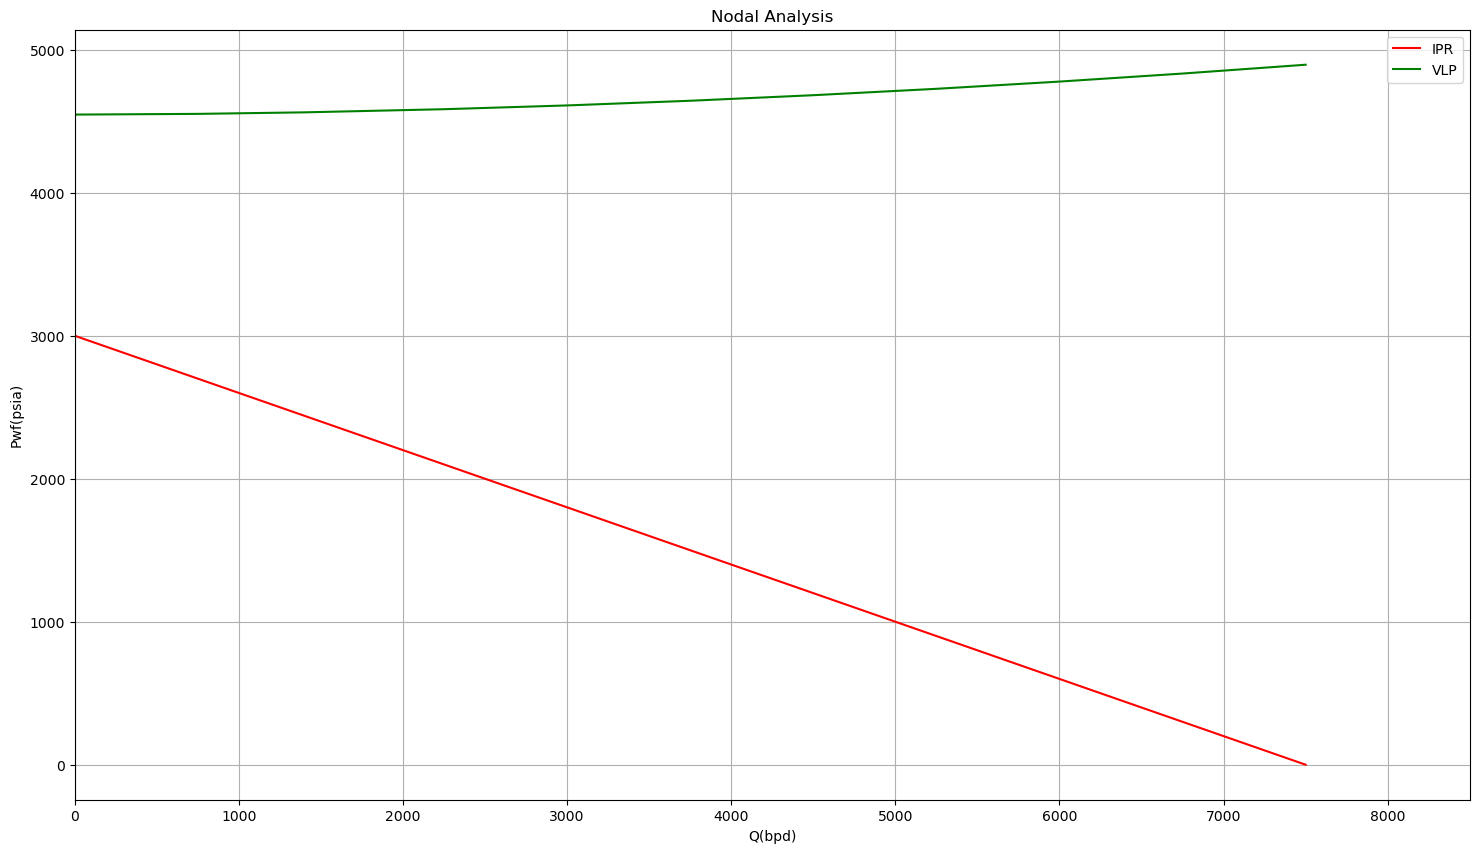

In [33]:
fig2, ax = plt.subplots(figsize=(18, 10))

ax.plot(df['Q(bpd)'].values, df['Pwf(psia)'].values, c='red', label='IPR')
ax.plot(df['Q(bpd)'].values, df['Po(psia)'].values, c='green', label='VLP')
#ax.plot(df['Q(bpd)'].values, df['Psys(psia)'].values, c='b', label='System Curve')
ax.set_xlabel('Q(bpd)')
ax.set_ylabel('Pwf(psia)')
ax.set_xlim(0, df['Q(bpd)'].max() + 1000)
ax.set_title('Nodal Analysis')
ax.grid()
plt.legend()
plt.show()

## Ejercicio 2

In [35]:
# Data
Pr = 3000 #psia
Pb = 2300 #psia
Qt = 1500 #bpd
Pwft = 2400 #psia
THP = 360 #psia
wc2 = 0.5
API = 20
sg_h2o = 1.09
ID = 3.5 #in
tvd = 9000 #ft
md = 10500 #ft
C = 120

## a) IP

In [36]:
IP = j(Qt, Pwft, Pr, Pb)
print(f"IP -> {IP} bpd/psia")

IP -> 2.5 bpd/psia


## b) Qmax

In [37]:
Qmax =  aof(Qt, Pwft, Pr, Pb)
print(f"Qmax -> {Qmax} bpd")

Qmax -> 7500.0 bpd


## SGavg

In [39]:
sgavg = sg_avg(API, wc2, sg_h2o)
print(f"Sgavg -> {sgavg:.2f}")

Sgavg -> 1.01


## d) Gavg

In [41]:
Gavg = gradient_avg(API, wc2, sg_h2o)
print(f"Gavg -> {Gavg:.2f} psi/ft")

Gavg -> 0.44 psi/ft


## e) Complete the table of values of P VS flow rate to calculate inflow and outflow pressures

In [44]:
columns = ['Q(bpd)', 'Pwf(psia)', 'THP(psia)', 'Pgravity(psia)', 'f', 'F(ft)', 'Pf(psia)', 'Po(psia)', 'Psys(psia)']
df2 = pd.DataFrame(columns=columns)

# Here the AOF is divided per 10 in order to evaluate the pwf for these 10 different flow rates
df2[columns[0]] = np.array([0, 750, 1400, 2250, 3000, 3750, 4500, 5250, 6000, 6750, 7500])
df2[columns[1]] = df2['Q(bpd)'].apply(lambda row: pwf_darcy(Qt, Pwft, row, Pr, Pb))
df2[columns[2]] = THP
df2[columns[3]] = gradient_avg(API, wc2, sg_h2o) * tvd
df2[columns[4]] = df2['Q(bpd)'].apply(lambda x: f_hanzenW(x, ID, C))
df2[columns[5]] = df2['f'] * md
df2[columns[6]] = gradient_avg(API, wc2, sg_h2o) * df2['F(ft)']
df2[columns[7]] = df2['THP(psia)'] + df2['Pgravity(psia)'] + df2['Pf(psia)']
df2[columns[8]] = df2['Po(psia)'] - df2['Pwf(psia)']

In [45]:
df2

,Q(bpd),Pwf(psia),THP(psia),Pgravity(psia),f,F(ft),Pf(psia),Po(psia),Psys(psia)
0,0,3000.0,360,3943.751139,0.000000,0.000000,0.000000,4303.751139,1303.751139
1,750,2700.0,360,3943.751139,0.001008,10.587646,4.639449,4308.390588,1608.390588
2,1400,2440.0,360,3943.751139,0.003200,33.594868,14.721089,4318.472227,1878.472227
3,2250,2100.0,360,3943.751139,0.007696,80.811605,35.411206,4339.162345,2239.162345
4,3000,1800.0,360,3943.751139,0.013105,137.597452,60.294457,4364.045595,2564.045595
5,3750,1500.0,360,3943.751139,0.019802,207.918875,91.108922,4394.860061,2894.860061
6,4500,1200.0,360,3943.751139,0.027745,291.325984,127.657465,4431.408603,3231.408603
7,5250,900.0,360,3943.751139,0.036901,387.463488,169.784397,4473.535535,3573.535535
8,6000,600.0,360,3943.751139,0.047242,496.039071,217.361628,4521.112766,3921.112766
9,6750,300.0,360,3943.751139,0.058743,616.805236,270.280706,4574.031844,4274.031844


## f) Plot Inflow, Outflow, and Systems curves con the graph

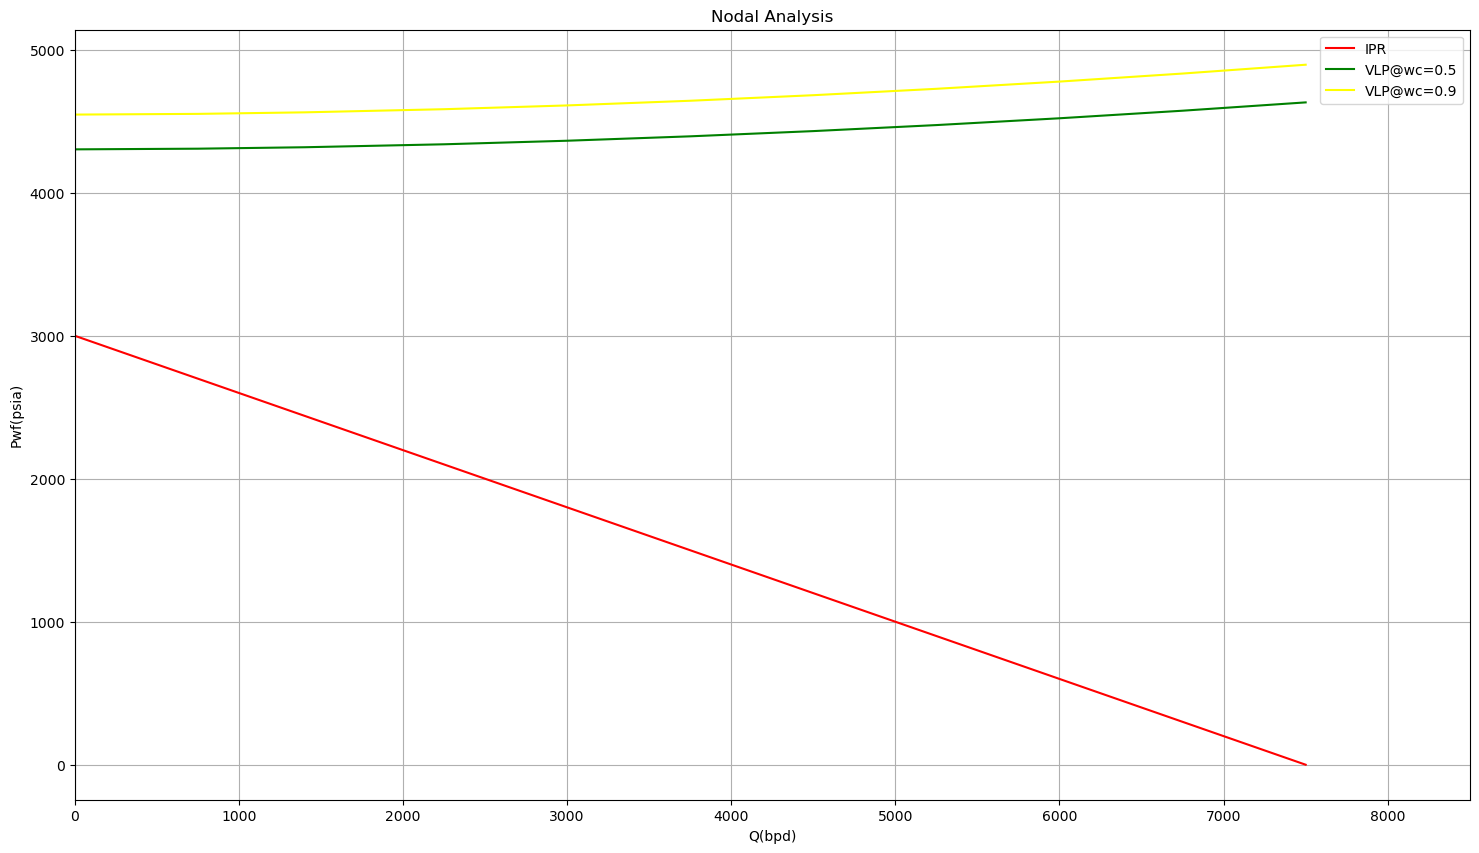

In [68]:
fig2, ax = plt.subplots(figsize=(18, 10))

ax.plot(df2['Q(bpd)'].values, df2['Pwf(psia)'].values, c='red', label='IPR')
ax.plot(df2['Q(bpd)'].values, df2['Po(psia)'].values, c='green', label='VLP@wc=0.5')
ax.plot(df["Q(bpd)"].values, df["Po(psia)"].values, c="yellow", label="VLP@wc=0.9")
#ax.plot(df['Q(bpd)'].values, df['Psys(psia)'].values, c='b', label='System Curve')
ax.set_xlabel('Q(bpd)')
ax.set_ylabel('Pwf(psia)')
ax.set_xlim(0, df2['Q(bpd)'].max() + 1000)
#ax.set_ylim(0, df2["Po(psia)"].max() + 800)
ax.set_title('Nodal Analysis')
ax.grid()
plt.legend()
plt.show()

## Ejercicio 3

In [69]:
# Data
Pr = 3000 #psia
Pb = 2300 #psia
Qt = 1500 #bpd
Pwft = 2400 #psia
THP = 360 # psia
wc = 0.9
sg_h2o = 1.09
Api = 20
ID = 3.5 #in
tvd = 9000 #ft
md = 10500 #ft
Nvl = 5000 #ft
C = 120

## a) IP

In [71]:
Ip = j(Qt, Pwft, Pr, Pb)
Ip

2.5

## b) AOF

In [72]:
Qmax = aof(Qt, Pwft, Pr, Pb)
Qmax

7500.0

## c) SG_Avg

In [73]:
Sgavg = sg_avg(Api, wc, sg_h2o)
Sgavg

1.0743993399339935

## d) Gradiente_avg

In [74]:
Gavg = gradient_avg(Api, wc, sg_h2o)
Gavg

0.4652149141914192

## e) Complete the table of values of P VS flow rate to calculate inflow and outflow pressures

In [75]:
columns = ['Q(bpd)', 'Pwf(psia)', 'THP(psia)', 'Pgravity(psia)', 'f', 'F(ft)', 'Pf(psia)', 'Po(psia)', 'Psys(psia)']
df3 = pd.DataFrame(columns=columns)

# Here the AOF is divided per 10 in order to evaluate the pwf for these 10 different flow rates
df3[columns[0]] = np.array([0, 750, 1400, 2250, 3000, 3750, 4500, 5250, 6000, 6750, 7500])
df3[columns[1]] = df2['Q(bpd)'].apply(lambda row: pwf_darcy(Qt, Pwft, row, Pr, Pb))
df3[columns[2]] = THP
df3[columns[3]] = gradient_avg(API, wc, sg_h2o) * Nvl
df3[columns[4]] = df3['Q(bpd)'].apply(lambda x: f_hanzenW(x, ID, C))
df3[columns[5]] = df3['f'] * md
df3[columns[6]] = gradient_avg(API, wc, sg_h2o) * df3['F(ft)']
df3[columns[7]] = df3['THP(psia)'] + df3['Pgravity(psia)'] + df3['Pf(psia)']
df3[columns[8]] = df3['Po(psia)'] - df3['Pwf(psia)']

In [77]:
df3

,Q(bpd),Pwf(psia),THP(psia),Pgravity(psia),f,F(ft),Pf(psia),Po(psia),Psys(psia)
0,0,3000.0,360,2326.074571,0.000000,0.000000,0.000000,2686.074571,-313.925429
1,750,2700.0,360,2326.074571,0.001008,10.587646,4.925531,2691.000102,-8.999898
2,1400,2440.0,360,2326.074571,0.003200,33.594868,15.628834,2701.703405,261.703405
3,2250,2100.0,360,2326.074571,0.007696,80.811605,37.594764,2723.669335,623.669335
4,3000,1800.0,360,2326.074571,0.013105,137.597452,64.012387,2750.086958,950.086958
5,3750,1500.0,360,2326.074571,0.019802,207.918875,96.726962,2782.801533,1282.801533
6,4500,1200.0,360,2326.074571,0.027745,291.325984,135.529193,2821.603764,1621.603764
7,5250,900.0,360,2326.074571,0.036901,387.463488,180.253793,2866.328364,1966.328364
8,6000,600.0,360,2326.074571,0.047242,496.039071,230.764774,2916.839345,2316.839345
9,6750,300.0,360,2326.074571,0.058743,616.805236,286.946995,2973.021566,2673.021566


## f) Plot Inflow, Outflow, and Systems curves con the graph

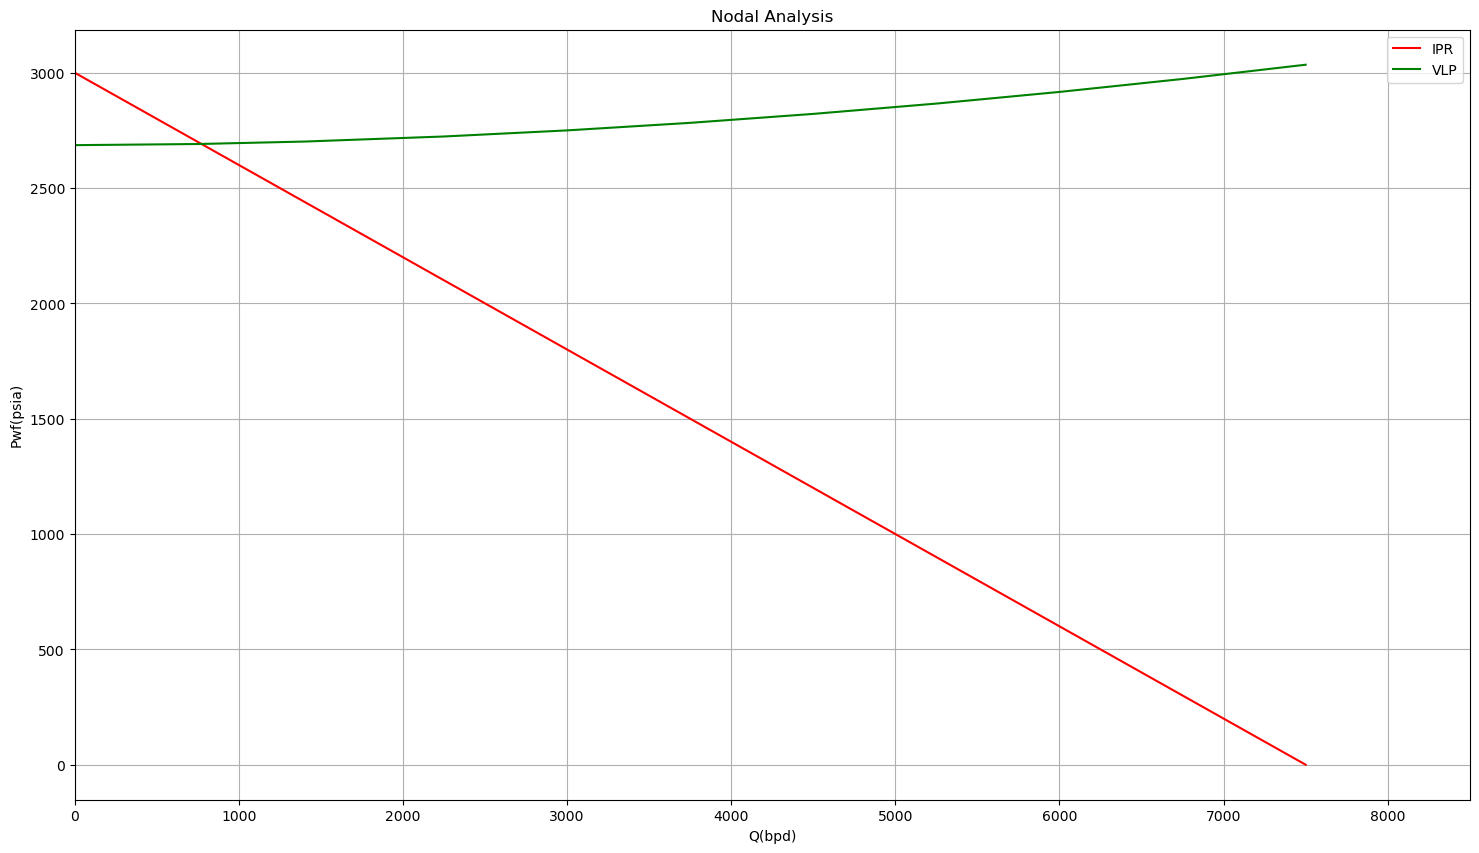

In [80]:
fig2, ax = plt.subplots(figsize=(18, 10))

ax.plot(df3['Q(bpd)'].values, df3['Pwf(psia)'].values, c='red', label='IPR')
ax.plot(df3['Q(bpd)'].values, df3['Po(psia)'].values, c='green', label='VLP')
#ax.plot(df['Q(bpd)'].values, df['Psys(psia)'].values, c='b', label='System Curve')
ax.set_xlabel('Q(bpd)')
ax.set_ylabel('Pwf(psia)')
ax.set_xlim(0, df2['Q(bpd)'].max() + 1000)
#ax.set_ylim(0, df2["Po(psia)"].max() + 800)
ax.set_title('Nodal Analysis')
ax.grid()
plt.legend()
plt.show()

## Ejercicio 4

In [25]:
# Datos
Pr = 3482 #psia
TVD = 10000 #ft
GLR = 400 #scf/stb
Pb = 3100 #psia
Pwh = 400 #psia
API = 35
fw = 0.5
Qt = 320 #bpd
Pwft = 3445 #psia
EF = 1

In [27]:
IP = j(Qt, Pwft, Pr, Pb)
print(f"{IP} bpd/psia")

8.64864864864865 bpd/psia


In [28]:
Q_max = aof(Qt, Pwft, Pr, Pb)
print(f"{Q_max} bpd")

30114.594594594597 bpd


## d) Gradiente_avg

## e) Complete the table of values of P VS flow rate to calculate inflow and outflow pressures

## f) Plot Inflow, Outflow, and Systems curves con the graph

## Ejercicio 5

In [81]:
# Datos (Flujo Multifasico)
Pr = 3482 #psia
TVD = 10000 #ft
GLR = 400 #scf/stb
Pb = 3100 #psia
Pwh = 400 #psia
API = 35
fw = 0.5
Qt = 320 #bpd
Pwft = 3445 #psia
EF = 1

In [82]:
QB = Qb(Qt, Pwft, Pr, Pb)
QB

3303.7837837837837

In [83]:
IP = j(Qt, Pwft, Pr, Pb)
print(f"{IP:.2f} bpd/psia")

8.65 bpd/psia


In [84]:
Q_max = aof(Qt, Pwft, Pr, Pb)
print(f"{Q_max:.2f} bpd")

30114.59 bpd


In [89]:
# Calculo de Pwf @ varios caudales
Tasas = np.array([500, 1000, 2000, 3000, 4000])
pwf_lr = [pwf_darcy(Qt, Pwft, q, Pr, Pb) for q in Tasas]
pwf_lr

[3424.1875, 3366.375, 3250.75, 3135.125, 3019.5]

In [86]:
Po_ID1 = [3000, 3020, 3200, 3270, 3520]

In [87]:
Po_ID2 = [3000, 3100, 3360, 3800]

In [88]:
Po_ID3 = [3120, 3360]

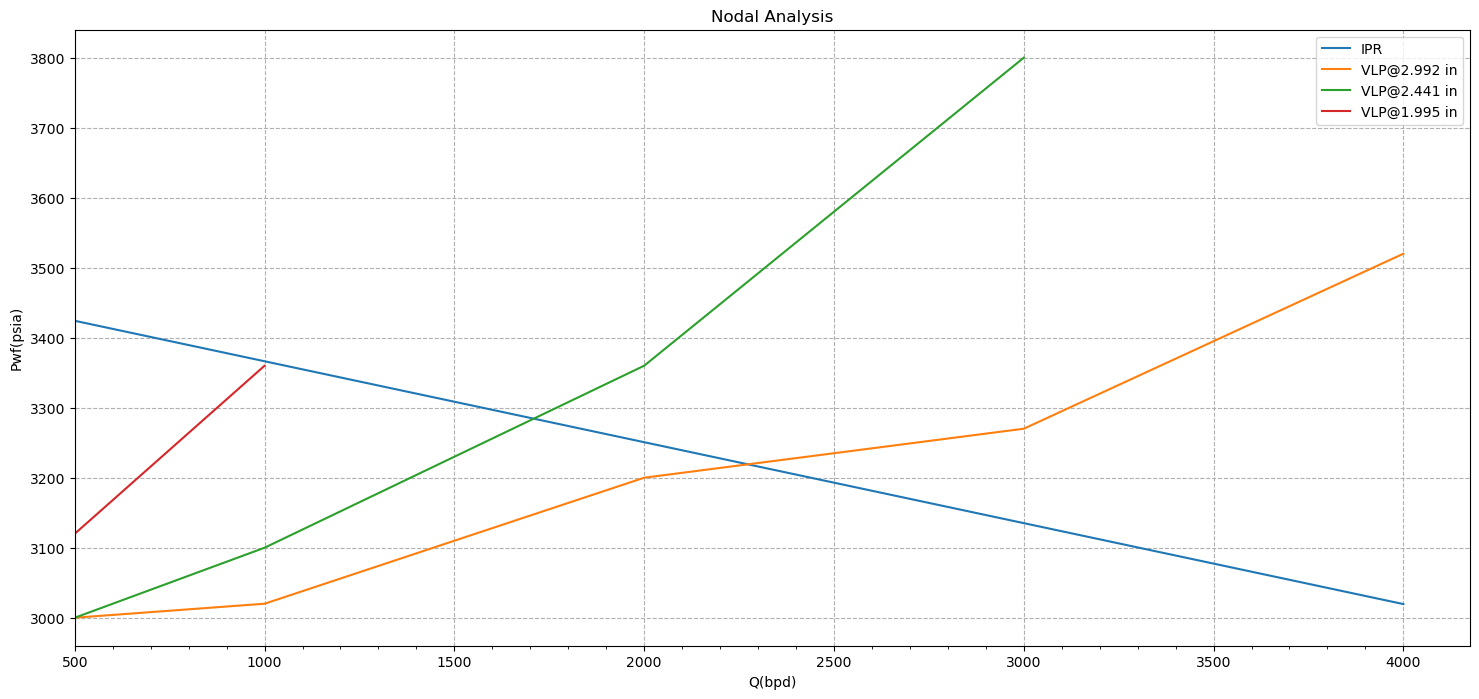

In [94]:
fig5, ax = plt.subplots(figsize = (18, 8))
ax.plot(Tasas, pwf_lr, label = 'IPR')
ax.plot(Tasas, Po_ID1, label ='VLP@2.992 in')
ax.plot(Tasas[:-1], Po_ID2, label = 'VLP@2.441 in')
ax.plot(Tasas[0:2], Po_ID3, label = 'VLP@1.995 in')
ax.set_xlabel('Q(bpd)')
ax.set_ylabel('Pwf(psia)')
ax.set_title('Nodal Analysis')
ax.set_xlim(min(Tasas))
#ax.set_ylim(bottom=3000)
ax.set_xticks(np.arange(500, 4000, 100), minor=True)
#ax.set_yticks(np.arange(3000, 4000, 100), minor=True)
ax.grid(linestyle='--')
plt.legend()
plt.show()